In [1]:
# Alpha RNN DK2 Electricity Example
# Author: 
# Version: 1.0 (12.2.2020)
# License: 
# Email: 
# Notes: tested on Mac OS X with Python 3.6 and TensorFlow 1.4

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
from numpy import random
import os# Generate switching data set
import random


# Imports for alpha_rnns 
from IPython import display
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l1,l2
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.preprocessing import StandardScaler

from keras import *
import keras.models
from alphaRNN import *
from alphatRNN import *

	
from numpy.random import seed
from tensorflow import set_random_seed

# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Using TensorFlow backend.


In [19]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50, min_delta=1e-6, restore_best_weights=True)

# Data Generation

In [4]:
df = pd.read_csv('Load7.csv')
df = pd.DataFrame(df)
df.head()

,utc_timestamp,DK_2_load_actual_net_consumption_tso,DK_2_load_actual_tso
0,2008-01-01T00:00:00Z,1468.0,1499.4
1,2008-01-01T01:00:00Z,1400.2,1439.4
2,2008-01-01T02:00:00Z,1334.8,1372.0
3,2008-01-01T03:00:00Z,1290.1,1324.9
4,2008-01-01T04:00:00Z,1286.1,1314.4


In [5]:
uni_data = df['DK_2_load_actual_net_consumption_tso']
uni_date = df['utc_timestamp']
uni_data.index = uni_date
uni_data.head()

utc_timestamp
2008-01-01T00:00:00Z    1468.0
2008-01-01T01:00:00Z    1400.2
2008-01-01T02:00:00Z    1334.8
2008-01-01T03:00:00Z    1290.1
2008-01-01T04:00:00Z    1286.1
Name: DK_2_load_actual_net_consumption_tso, dtype: float64

In [6]:
use_features = ['DK_2_load_actual_net_consumption_tso']
target = 'DK_2_load_actual_net_consumption_tso'

n_steps = 30 # number of lags to include in the model

train_weight = 0.8 # train/test sploit

split = int(len(df)*train_weight)
df_train = df[use_features].iloc[:split]
mu = np.float(df_train[use_features].mean())
sigma = np.float(df_train[use_features].std())
std_df_train = df_train[use_features].apply(lambda x: (x - mu) / sigma)

df_train = std_df_train 
std_df_test = df[use_features].apply(lambda x: (x-mu)/sigma).iloc[split:]
df_test = std_df_test

## Statistical diagnostics

## Augmented Dickey-Fuller test

In [8]:
adf, p, usedlag, nobs, cvs,aic=sm.tsa.stattools.adfuller(df['DK_2_load_actual_net_consumption_tso'][:2000], regression='ct', maxlag=30)
print(adf,p, nobs, cvs)

-6.147178010841611 1.071996639935344e-06 1970 {'1%': -3.9633728248857185, '5%': -3.4127209637023594, '10%': -3.128363501600249}


In [9]:
pacf=sm.tsa.stattools.pacf(df[use_features], nlags=75)

[ 1.          0.95869224 -0.78468411  0.25597489 -0.24503089  0.07696352
  0.06027825  0.04656948  0.02207589 -0.0342775  -0.12844243  0.01361154
  0.21274128  0.0271157  -0.00395558  0.18832094  0.26271402  0.17903612
  0.27500886  0.21321348  0.18391544  0.24179789  0.24270386 -0.02057275
 -0.44037336 -0.49887036  0.25897333 -0.06018779  0.0282418   0.00209932
  0.04368898  0.0207136  -0.05294792 -0.05176967  0.00273881  0.0209483
  0.02859691  0.01350573 -0.0375535  -0.0238018  -0.01615046 -0.01453972
  0.03956624  0.03314696 -0.00702568  0.01773658  0.00520414  0.01548065
 -0.03919206 -0.10010371  0.14992878 -0.06932014  0.01395849 -0.01600043
  0.03274036  0.01459499 -0.01020564  0.0037985   0.04368231  0.02375848
 -0.01113843  0.01358194  0.02174117  0.02947851  0.05393095  0.07272289
  0.06230925  0.05656046  0.03770286  0.0480605   0.03369425 -0.0138217
 -0.11290996 -0.14944869  0.08581554 -0.02389512]


In [0]:
#n_steps=np.where(np.array(np.abs(pacf)>2.58/np.sqrt(len(df[use_features])))==False)[0][0] -1

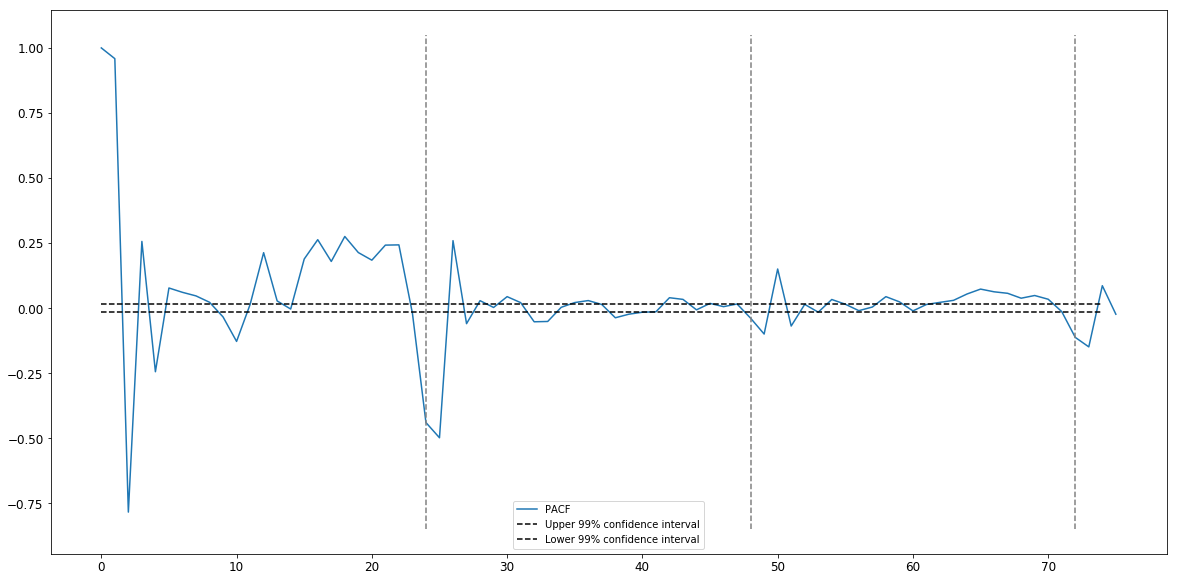

In [11]:
plt.figure(figsize=(20,10))

plt.plot(pacf, label='PACF')
plt.plot([2.58/np.sqrt(len(df[use_features]))]*75, label='Upper 99% confidence interval', color='black', linestyle='--')
plt.plot([-2.58/np.sqrt(len(df[use_features]))]*75, label='Lower 99% confidence interval', color='black', linestyle='--')
# show daily lags
plt.plot(24*np.ones(len(np.arange(-0.85,1.1,0.05))), np.arange(-0.85,1.1,0.05), linestyle='--', color='grey')
plt.plot(48*np.ones(len(np.arange(-0.85,1.1,0.05))), np.arange(-0.85,1.1,0.05), linestyle='--', color='grey')
plt.plot(72*np.ones(len(np.arange(-0.85,1.1,0.05))), np.arange(-0.85,1.1,0.05), linestyle='--', color='grey')

plt.legend()

### Data structure manipulation for RNNs

In [13]:
def get_lagged_features(value, n_steps,n_steps_ahead):
    """
    value: feature value to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    for lag in range(n_steps+n_steps_ahead-1, n_steps_ahead-1, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [25]:
n_steps_ahead=10

x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(df_train, n_steps, n_steps_ahead).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps,n_steps_ahead).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

In [26]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)

(23960, 30, 1) (23960, 1, 1) (5961, 30, 1) (5961, 1, 1)


In [27]:
train_batch_size = y_train_reg.shape[0]
test_batch_size = y_test_reg.shape[0]

In [28]:
print(train_batch_size)

23960


In [29]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))


x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

### Keras Wrappers

In [30]:
def AlphatRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(AlphatRNN(n_units, activation='tanh', recurrent_activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def AlphaRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def SimpleRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def GRU_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def LSTM_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True)) 
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [31]:
max_epoches=2000
batch_size=1000

In [32]:
params = {'rnn': {'model':'', 'function':SimpleRNN_, 'l1_reg':0.0, 'H':20, 'color': 'blue', 'label':'RNN'}, 
          'alpharnn': {'model':'', 'function':AlphaRNN_,'l1_reg':0.0, 'H':20,'color': 'green', 'label': '$\\alpha$-RNN' }, 
          'alphatrnn': {'model':'', 'function':AlphatRNN_,'l1_reg':0.0, 'H':20, 'color': 'cyan', 'label': '$\\alpha_t$-RNN'},
          'gru': {'model':'', 'function':GRU_,'l1_reg':0.0, 'H':20, 'color': 'orange', 'label': 'GRU'},
          'lstm': {'model':'', 'function':LSTM_,'l1_reg':0.0, 'H':20, 'color':'red', 'label': 'LSTM'}
         }

In [33]:
cross_val=False # Warning: Changing this to True will take several hours to run
if cross_val:
    n_units = [5,10,20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    tscv = TimeSeriesSplit(n_splits = 5)
    param_grid = dict(n_units=n_units,l1_reg=l1_reg)

    for key in params.keys(): # params[key]['function']
        model = KerasRegressor(build_fn=params[key]['function'], epochs=max_epoches, batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))

    params[key]['H'] = grid_result.best_params_['n_units']
    params[key]['l1_reg']= grid_result.best_params_['l1_reg']

# Train cross-validated model

In [ ]:
for key in params.keys():
    set_random_seed(0)
    model=params[key]['function'](params[key]['H'],params[key]['l1_reg'])
    model.fit(x_train_reg,y_train_reg,epochs=max_epoches, batch_size=batch_size,callbacks=[es],shuffle=False)
    params[key]['model']=model

Epoch 1/2000
23960/23960 [==============================] - 1s 29us/step - loss: 2.2004
Epoch 2/2000
23960/23960 [==============================] - 0s 6us/step - loss: 1.7647
Epoch 3/2000
23960/23960 [==============================] - 0s 6us/step - loss: 1.5687
Epoch 4/2000
23960/23960 [==============================] - 0s 6us/step - loss: 1.4162
Epoch 5/2000
23960/23960 [==============================] - 0s 6us/step - loss: 1.2638
Epoch 6/2000
23960/23960 [==============================] - 0s 7us/step - loss: 1.1322
Epoch 7/2000
23960/23960 [==============================] - 0s 6us/step - loss: 1.0575
Epoch 8/2000
23960/23960 [==============================] - 0s 6us/step - loss: 1.0218
Epoch 9/2000
23960/23960 [==============================] - 0s 6us/step - loss: 1.0025
Epoch 10/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.9918
Epoch 11/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.9857
Epoch 12/2000
23960/23960 [=============

23960/23960 [==============================] - 0s 7us/step - loss: 0.1910
Epoch 94/2000
23960/23960 [==============================] - 0s 8us/step - loss: 0.1902
Epoch 95/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1895
Epoch 96/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1887
Epoch 97/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1880
Epoch 98/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1873
Epoch 99/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1866
Epoch 100/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1860
Epoch 101/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1853
Epoch 102/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1846
Epoch 103/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1840
Epoch 104/2000
23960/23960 [==============

23960/23960 [==============================] - 0s 7us/step - loss: 0.1594
Epoch 186/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.1537
Epoch 187/2000
23960/23960 [==============================] - 0s 8us/step - loss: 0.1491
Epoch 188/2000
23960/23960 [==============================] - 0s 8us/step - loss: 0.1494
Epoch 189/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1505
Epoch 190/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1501
Epoch 191/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1485
Epoch 192/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1474
Epoch 193/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1474
Epoch 194/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1479
Epoch 195/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1482
Epoch 196/2000
23960/23960 [========

23960/23960 [==============================] - 0s 7us/step - loss: 0.1346
Epoch 278/2000
23960/23960 [==============================] - 0s 8us/step - loss: 0.1326
Epoch 279/2000
23960/23960 [==============================] - 0s 8us/step - loss: 0.1336
Epoch 280/2000
23960/23960 [==============================] - 0s 8us/step - loss: 0.1343
Epoch 281/2000
23960/23960 [==============================] - 0s 8us/step - loss: 0.1344
Epoch 282/2000
23960/23960 [==============================] - 0s 8us/step - loss: 0.1354
Epoch 283/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1357
Epoch 284/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1344
Epoch 285/2000
23960/23960 [==============================] - 0s 8us/step - loss: 0.1321
Epoch 286/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1309
Epoch 287/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1315
Epoch 288/2000
23960/23960 [========

23960/23960 [==============================] - 0s 7us/step - loss: 0.1232
Epoch 370/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1231
Epoch 371/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1229
Epoch 372/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1228
Epoch 373/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1227
Epoch 374/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1226
Epoch 375/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1225
Epoch 376/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1224
Epoch 377/2000
23960/23960 [==============================] - 0s 8us/step - loss: 0.1223
Epoch 378/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1222
Epoch 379/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1221
Epoch 380/2000
23960/23960 [========

23960/23960 [==============================] - 0s 6us/step - loss: 0.1167
Epoch 462/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1167
Epoch 463/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1167
Epoch 464/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1168
Epoch 465/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1167
Epoch 466/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1169
Epoch 467/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1166
Epoch 468/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1170
Epoch 469/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1165
Epoch 470/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1169
Epoch 471/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1163
Epoch 472/2000
23960/23960 [========

23960/23960 [==============================] - 0s 6us/step - loss: 0.1115
Epoch 554/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1137
Epoch 555/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1114
Epoch 556/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1136
Epoch 557/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1113
Epoch 558/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1136
Epoch 559/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1112
Epoch 560/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1136
Epoch 561/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1111
Epoch 562/2000
23960/23960 [==============================] - 0s 8us/step - loss: 0.1135
Epoch 563/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1110
Epoch 564/2000
23960/23960 [========

23960/23960 [==============================] - 0s 6us/step - loss: 0.1050
Epoch 646/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1077
Epoch 647/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1045
Epoch 648/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1072
Epoch 649/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1042
Epoch 650/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1068
Epoch 651/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1040
Epoch 652/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1065
Epoch 653/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1037
Epoch 654/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1058
Epoch 655/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1036
Epoch 656/2000
23960/23960 [========

23960/23960 [==============================] - 0s 6us/step - loss: 0.0974
Epoch 738/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1008
Epoch 739/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1039
Epoch 740/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1023
Epoch 741/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.0995
Epoch 742/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.0989
Epoch 743/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1004
Epoch 744/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1005
Epoch 745/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.0994
Epoch 746/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1004
Epoch 747/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.0988
Epoch 748/2000
23960/23960 [========

23960/23960 [==============================] - 0s 6us/step - loss: 0.0955
Epoch 830/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.0975
Epoch 831/2000
23960/23960 [==============================] - 0s 7us/step - loss: 0.1006
Epoch 832/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.0966
Epoch 833/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.0988
Epoch 834/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.1078
Epoch 835/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.0980
Epoch 836/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.0981
Epoch 837/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.0950
Epoch 838/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.0947
Epoch 839/2000
23960/23960 [==============================] - 0s 6us/step - loss: 0.0926
Epoch 840/2000
23960/23960 [========

23960/23960 [==============================] - 0s 10us/step - loss: 0.8681
Epoch 45/2000
23960/23960 [==============================] - 0s 8us/step - loss: 0.8431
Epoch 46/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.8213
Epoch 47/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.8023
Epoch 48/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.7858
Epoch 49/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.7713
Epoch 50/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.7585
Epoch 51/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.7470
Epoch 52/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.7365
Epoch 53/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.7268
Epoch 54/2000
23960/23960 [==============================] - 0s 8us/step - loss: 0.7178
Epoch 55/2000
23960/23960 [=================

23960/23960 [==============================] - 0s 9us/step - loss: 0.3603
Epoch 137/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.3593
Epoch 138/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.3584
Epoch 139/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.3576
Epoch 140/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.3567
Epoch 141/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.3559
Epoch 142/2000
23960/23960 [==============================] - 0s 8us/step - loss: 0.3552
Epoch 143/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.3544
Epoch 144/2000
23960/23960 [==============================] - 0s 8us/step - loss: 0.3537
Epoch 145/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.3531
Epoch 146/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.3524
Epoch 147/2000
23960/23960 [========

Epoch 228/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.3041
Epoch 229/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.3034
Epoch 230/2000
23960/23960 [==============================] - 0s 8us/step - loss: 0.3027
Epoch 231/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.3021
Epoch 232/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.3014
Epoch 233/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.3008
Epoch 234/2000
23960/23960 [==============================] - 0s 8us/step - loss: 0.3001
Epoch 235/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.2995
Epoch 236/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.2989
Epoch 237/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.2983
Epoch 238/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.2977
Epoch 239/2000
2396

Epoch 320/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.2424
Epoch 321/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.2699
Epoch 322/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.2322
Epoch 323/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.2930
Epoch 324/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.2312
Epoch 325/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.2950
Epoch 326/2000
23960/23960 [==============================] - 0s 8us/step - loss: 0.2293
Epoch 327/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.2869
Epoch 328/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.2240
Epoch 329/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.2689
Epoch 330/2000
23960/23960 [==============================] - 0s 9us/step - loss: 0.2293
Epoch 331/2000
23960/

23960/23960 [==============================] - 0s 11us/step - loss: 0.2313
Epoch 412/2000
23960/23960 [==============================] - 0s 11us/step - loss: 0.1992
Epoch 413/2000
23960/23960 [==============================] - 0s 11us/step - loss: 0.2312
Epoch 414/2000
23960/23960 [==============================] - 0s 12us/step - loss: 0.1988
Epoch 415/2000
23960/23960 [==============================] - 0s 11us/step - loss: 0.2327
Epoch 416/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1993
Epoch 417/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.2350
Epoch 418/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.2002
Epoch 419/2000
23960/23960 [==============================] - 0s 11us/step - loss: 0.2366
Epoch 420/2000
23960/23960 [==============================] - 0s 12us/step - loss: 0.2009
Epoch 421/2000
23960/23960 [==============================] - 0s 12us/step - loss: 0.2361
Epoch 422/2000
23960/2396

23960/23960 [==============================] - 0s 12us/step - loss: 0.1869
Epoch 503/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.2140
Epoch 504/2000
23960/23960 [==============================] - 0s 12us/step - loss: 0.1859
Epoch 505/2000
23960/23960 [==============================] - 0s 11us/step - loss: 0.2130
Epoch 506/2000
23960/23960 [==============================] - 0s 11us/step - loss: 0.1847
Epoch 507/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.2099
Epoch 508/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1830
Epoch 509/2000
23960/23960 [==============================] - 0s 11us/step - loss: 0.2060
Epoch 510/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1812
Epoch 511/2000
23960/23960 [==============================] - 0s 11us/step - loss: 0.2025
Epoch 512/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1797
Epoch 513/2000
23960/2396

23960/23960 [==============================] - 0s 12us/step - loss: 0.1916
Epoch 594/2000
23960/23960 [==============================] - 0s 11us/step - loss: 0.1738
Epoch 595/2000
23960/23960 [==============================] - 0s 11us/step - loss: 0.1908
Epoch 596/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1729
Epoch 597/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1898
Epoch 598/2000
23960/23960 [==============================] - 0s 11us/step - loss: 0.1719
Epoch 599/2000
23960/23960 [==============================] - 0s 12us/step - loss: 0.1887
Epoch 600/2000
23960/23960 [==============================] - 0s 13us/step - loss: 0.1708
Epoch 601/2000
23960/23960 [==============================] - 0s 11us/step - loss: 0.1877
Epoch 602/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1693
Epoch 603/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1868
Epoch 604/2000
23960/2396

23960/23960 [==============================] - 0s 11us/step - loss: 0.1676
Epoch 685/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1916
Epoch 686/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1703
Epoch 687/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1733
Epoch 688/2000
23960/23960 [==============================] - 0s 11us/step - loss: 0.1484
Epoch 689/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1660
Epoch 690/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1401
Epoch 691/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1579
Epoch 692/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1366
Epoch 693/2000
23960/23960 [==============================] - 0s 12us/step - loss: 0.1498
Epoch 694/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1375
Epoch 695/2000
23960/2396

23960/23960 [==============================] - 0s 11us/step - loss: 0.1287
Epoch 776/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1288
Epoch 777/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1283
Epoch 778/2000
23960/23960 [==============================] - 0s 11us/step - loss: 0.1294
Epoch 779/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1397
Epoch 780/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1486
Epoch 781/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1614
Epoch 782/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1759
Epoch 783/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1686
Epoch 784/2000
23960/23960 [==============================] - 0s 11us/step - loss: 0.1522
Epoch 785/2000
23960/23960 [==============================] - 0s 10us/step - loss: 0.1428
Epoch 786/2000
23960/2396

23960/23960 [==============================] - 1s 24us/step - loss: 0.3939
Epoch 20/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.3634
Epoch 21/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.3356
Epoch 22/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.3116
Epoch 23/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.2922
Epoch 24/2000
23960/23960 [==============================] - 1s 27us/step - loss: 0.2773
Epoch 25/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.2661
Epoch 26/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.2575
Epoch 27/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.2506
Epoch 28/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.2446
Epoch 29/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.2393
Epoch 30/2000
23960/23960 [========

23960/23960 [==============================] - 0s 18us/step - loss: 0.1138
Epoch 112/2000
23960/23960 [==============================] - 0s 19us/step - loss: 0.1134
Epoch 113/2000
23960/23960 [==============================] - 0s 18us/step - loss: 0.1131
Epoch 114/2000
23960/23960 [==============================] - 0s 19us/step - loss: 0.1127
Epoch 115/2000
23960/23960 [==============================] - 0s 18us/step - loss: 0.1124
Epoch 116/2000
23960/23960 [==============================] - 0s 20us/step - loss: 0.1120
Epoch 117/2000
23960/23960 [==============================] - 0s 18us/step - loss: 0.1117
Epoch 118/2000
23960/23960 [==============================] - 1s 22us/step - loss: 0.1113
Epoch 119/2000
23960/23960 [==============================] - 1s 21us/step - loss: 0.1110
Epoch 120/2000
23960/23960 [==============================] - 0s 18us/step - loss: 0.1106
Epoch 121/2000
23960/23960 [==============================] - 0s 19us/step - loss: 0.1103
Epoch 122/2000
23960/2396

23960/23960 [==============================] - 0s 20us/step - loss: 0.0942
Epoch 203/2000
23960/23960 [==============================] - 0s 19us/step - loss: 0.0940
Epoch 204/2000
23960/23960 [==============================] - 0s 20us/step - loss: 0.0939
Epoch 205/2000
23960/23960 [==============================] - 0s 20us/step - loss: 0.0938
Epoch 206/2000
23960/23960 [==============================] - 1s 21us/step - loss: 0.0937
Epoch 207/2000
23960/23960 [==============================] - 1s 22us/step - loss: 0.0936
Epoch 208/2000
23960/23960 [==============================] - 0s 20us/step - loss: 0.0935
Epoch 209/2000
23960/23960 [==============================] - 1s 21us/step - loss: 0.0934
Epoch 210/2000
23960/23960 [==============================] - 1s 21us/step - loss: 0.0933
Epoch 211/2000
23960/23960 [==============================] - 1s 21us/step - loss: 0.0932
Epoch 212/2000
23960/23960 [==============================] - 1s 22us/step - loss: 0.0931
Epoch 213/2000
23960/2396

23960/23960 [==============================] - 1s 22us/step - loss: 0.0870
Epoch 294/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0870
Epoch 295/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0869
Epoch 296/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0869
Epoch 297/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0868
Epoch 298/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0867
Epoch 299/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0867
Epoch 300/2000
23960/23960 [==============================] - 1s 21us/step - loss: 0.0866
Epoch 301/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0866
Epoch 302/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0865
Epoch 303/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0864
Epoch 304/2000
23960/2396

23960/23960 [==============================] - 1s 25us/step - loss: 0.0820
Epoch 385/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0820
Epoch 386/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0819
Epoch 387/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0819
Epoch 388/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0818
Epoch 389/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0818
Epoch 390/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0817
Epoch 391/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0817
Epoch 392/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0816
Epoch 393/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0816
Epoch 394/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0815
Epoch 395/2000
23960/2396

23960/23960 [==============================] - 1s 24us/step - loss: 0.0779
Epoch 476/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0779
Epoch 477/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0778
Epoch 478/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0778
Epoch 479/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0778
Epoch 480/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0777
Epoch 481/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0777
Epoch 482/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0776
Epoch 483/2000
23960/23960 [==============================] - 1s 29us/step - loss: 0.0776
Epoch 484/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0776
Epoch 485/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0775
Epoch 486/2000
23960/2396

23960/23960 [==============================] - 0s 20us/step - loss: 0.0748
Epoch 567/2000
23960/23960 [==============================] - 0s 20us/step - loss: 0.0747
Epoch 568/2000
23960/23960 [==============================] - 0s 21us/step - loss: 0.0747
Epoch 569/2000
23960/23960 [==============================] - 1s 21us/step - loss: 0.0747
Epoch 570/2000
23960/23960 [==============================] - 1s 22us/step - loss: 0.0747
Epoch 571/2000
23960/23960 [==============================] - 0s 19us/step - loss: 0.0746
Epoch 572/2000
23960/23960 [==============================] - 0s 20us/step - loss: 0.0746
Epoch 573/2000
23960/23960 [==============================] - 0s 20us/step - loss: 0.0745
Epoch 574/2000
23960/23960 [==============================] - 1s 21us/step - loss: 0.0745
Epoch 575/2000
23960/23960 [==============================] - 1s 22us/step - loss: 0.0745
Epoch 576/2000
23960/23960 [==============================] - 0s 21us/step - loss: 0.0745
Epoch 577/2000
23960/2396

23960/23960 [==============================] - 1s 23us/step - loss: 0.0715
Epoch 658/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0715
Epoch 659/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0714
Epoch 660/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0714
Epoch 661/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0713
Epoch 662/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0713
Epoch 663/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0713
Epoch 664/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0712
Epoch 665/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0712
Epoch 666/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0711
Epoch 667/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0711
Epoch 668/2000
23960/2396

23960/23960 [==============================] - 1s 25us/step - loss: 0.0678
Epoch 749/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0677
Epoch 750/2000
23960/23960 [==============================] - 1s 22us/step - loss: 0.0677
Epoch 751/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0677
Epoch 752/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0676
Epoch 753/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0676
Epoch 754/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0675
Epoch 755/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0675
Epoch 756/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0675
Epoch 757/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0674
Epoch 758/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0674
Epoch 759/2000
23960/2396

23960/23960 [==============================] - 1s 22us/step - loss: 0.0641
Epoch 840/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0629
Epoch 841/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0634
Epoch 842/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0661
Epoch 843/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0684
Epoch 844/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0660
Epoch 845/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0627
Epoch 846/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0625
Epoch 847/2000
23960/23960 [==============================] - 1s 28us/step - loss: 0.0656
Epoch 848/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0685
Epoch 849/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0659
Epoch 850/2000
23960/2396

23960/23960 [==============================] - 1s 25us/step - loss: 0.0598
Epoch 931/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0616
Epoch 932/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0639
Epoch 933/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0625
Epoch 934/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0600
Epoch 935/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0599
Epoch 936/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0621
Epoch 937/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0639
Epoch 938/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0616
Epoch 939/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0597
Epoch 940/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0601
Epoch 941/2000
23960/2396

23960/23960 [==============================] - 1s 28us/step - loss: 0.0617
Epoch 1021/2000
23960/23960 [==============================] - 1s 28us/step - loss: 0.0605
Epoch 1022/2000
23960/23960 [==============================] - 1s 28us/step - loss: 0.0579
Epoch 1023/2000
23960/23960 [==============================] - 1s 28us/step - loss: 0.0576
Epoch 1024/2000
23960/23960 [==============================] - 1s 28us/step - loss: 0.0602
Epoch 1025/2000
23960/23960 [==============================] - 1s 27us/step - loss: 0.0617
Epoch 1026/2000
23960/23960 [==============================] - 1s 29us/step - loss: 0.0588
Epoch 1027/2000
23960/23960 [==============================] - 1s 28us/step - loss: 0.0574
Epoch 1028/2000
23960/23960 [==============================] - 1s 28us/step - loss: 0.0586
Epoch 1029/2000
23960/23960 [==============================] - 1s 28us/step - loss: 0.0614
Epoch 1030/2000
23960/23960 [==============================] - 1s 28us/step - loss: 0.0603
Epoch 1031/2000

23960/23960 [==============================] - 1s 23us/step - loss: 0.0574
Epoch 1111/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0601
Epoch 1112/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0573
Epoch 1113/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0557
Epoch 1114/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0572
Epoch 1115/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0596
Epoch 1116/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0567
Epoch 1117/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0554
Epoch 1118/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0572
Epoch 1119/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0593
Epoch 1120/2000
23960/23960 [==============================] - 1s 22us/step - loss: 0.0564
Epoch 1121/2000

23960/23960 [==============================] - 1s 26us/step - loss: 0.0531
Epoch 1201/2000
23960/23960 [==============================] - 1s 27us/step - loss: 0.0535
Epoch 1202/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0530
Epoch 1203/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0534
Epoch 1204/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0530
Epoch 1205/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0532
Epoch 1206/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0531
Epoch 1207/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0529
Epoch 1208/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0534
Epoch 1209/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0528
Epoch 1210/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.0536
Epoch 1211/2000

23960/23960 [==============================] - 1s 30us/step - loss: 0.0532
Epoch 1291/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0513
Epoch 1292/2000
23960/23960 [==============================] - 1s 27us/step - loss: 0.0519
Epoch 1293/2000
23960/23960 [==============================] - 1s 28us/step - loss: 0.0511
Epoch 1294/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0519
Epoch 1295/2000
23960/23960 [==============================] - 1s 28us/step - loss: 0.0511
Epoch 1296/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0520
Epoch 1297/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0512
Epoch 1298/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0518
Epoch 1299/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0512
Epoch 1300/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0514
Epoch 1301/2000

23960/23960 [==============================] - 1s 27us/step - loss: 0.0490
Epoch 1381/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0495
Epoch 1382/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.0492
Epoch 1383/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0490
Epoch 1384/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0501
Epoch 1385/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0494
Epoch 1386/2000
23960/23960 [==============================] - 1s 27us/step - loss: 0.0501
Epoch 1387/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0502
Epoch 1388/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0497
Epoch 1389/2000
23960/23960 [==============================] - 1s 28us/step - loss: 0.0523
Epoch 1390/2000
23960/23960 [==============================] - 1s 27us/step - loss: 0.0508
Epoch 1391/2000

23960/23960 [==============================] - 1s 24us/step - loss: 0.0493
Epoch 1471/2000
23960/23960 [==============================] - 1s 27us/step - loss: 0.0485
Epoch 1472/2000
23960/23960 [==============================] - 1s 27us/step - loss: 0.0497
Epoch 1473/2000
23960/23960 [==============================] - 1s 27us/step - loss: 0.0489
Epoch 1474/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0505
Epoch 1475/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0497
Epoch 1476/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0519
Epoch 1477/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0508
Epoch 1478/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0533
Epoch 1479/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0514
Epoch 1480/2000
23960/23960 [==============================] - 1s 29us/step - loss: 0.0532
Epoch 1481/2000

Epoch 72/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.1320
Epoch 73/2000
23960/23960 [==============================] - 1s 23us/step - loss: 0.1312
Epoch 74/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.1304
Epoch 75/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.1296
Epoch 76/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.1288
Epoch 77/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.1281
Epoch 78/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.1275
Epoch 79/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.1268
Epoch 80/2000
23960/23960 [==============================] - 1s 24us/step - loss: 0.1262
Epoch 81/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.1256
Epoch 82/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.1251
Epoch 83/2000
23960/2

23960/23960 [==============================] - 0s 19us/step - loss: 0.1016
Epoch 164/2000
23960/23960 [==============================] - 0s 19us/step - loss: 0.1015
Epoch 165/2000
23960/23960 [==============================] - 0s 19us/step - loss: 0.1014
Epoch 166/2000
23960/23960 [==============================] - 0s 20us/step - loss: 0.1011
Epoch 167/2000
23960/23960 [==============================] - 0s 19us/step - loss: 0.1009
Epoch 168/2000
23960/23960 [==============================] - 0s 19us/step - loss: 0.1005
Epoch 169/2000
23960/23960 [==============================] - 0s 18us/step - loss: 0.1001
Epoch 170/2000
23960/23960 [==============================] - 0s 17us/step - loss: 0.1001
Epoch 171/2000
23960/23960 [==============================] - 0s 19us/step - loss: 0.1004
Epoch 172/2000
23960/23960 [==============================] - 0s 20us/step - loss: 0.1008
Epoch 173/2000
23960/23960 [==============================] - 0s 20us/step - loss: 0.1006
Epoch 174/2000
23960/2396

23960/23960 [==============================] - 1s 27us/step - loss: 0.0916
Epoch 255/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0915
Epoch 256/2000
23960/23960 [==============================] - 1s 27us/step - loss: 0.0914
Epoch 257/2000
23960/23960 [==============================] - 1s 28us/step - loss: 0.0914
Epoch 258/2000
23960/23960 [==============================] - 1s 29us/step - loss: 0.0912
Epoch 259/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0911
Epoch 260/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0911
Epoch 261/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0910
Epoch 262/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0909
Epoch 263/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0907
Epoch 264/2000
23960/23960 [==============================] - 1s 27us/step - loss: 0.0906
Epoch 265/2000
23960/2396

23960/23960 [==============================] - 1s 24us/step - loss: 0.0833
Epoch 346/2000
23960/23960 [==============================] - 1s 27us/step - loss: 0.0832
Epoch 347/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0832
Epoch 348/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0831
Epoch 349/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0830
Epoch 350/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0829
Epoch 351/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0829
Epoch 352/2000
23960/23960 [==============================] - 1s 25us/step - loss: 0.0828
Epoch 353/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0826
Epoch 354/2000
23960/23960 [==============================] - 1s 30us/step - loss: 0.0825
Epoch 355/2000
23960/23960 [==============================] - 1s 27us/step - loss: 0.0825
Epoch 356/2000
23960/2396

23960/23960 [==============================] - 1s 41us/step - loss: 0.0763
Epoch 437/2000
23960/23960 [==============================] - 1s 38us/step - loss: 0.0762
Epoch 438/2000
23960/23960 [==============================] - 1s 38us/step - loss: 0.0761
Epoch 439/2000
23960/23960 [==============================] - 1s 38us/step - loss: 0.0760
Epoch 440/2000
23960/23960 [==============================] - 1s 35us/step - loss: 0.0760
Epoch 441/2000
23960/23960 [==============================] - 1s 36us/step - loss: 0.0759
Epoch 442/2000
23960/23960 [==============================] - 1s 35us/step - loss: 0.0759
Epoch 443/2000
23960/23960 [==============================] - 1s 38us/step - loss: 0.0758
Epoch 444/2000
23960/23960 [==============================] - 1s 37us/step - loss: 0.0758
Epoch 445/2000
23960/23960 [==============================] - 1s 39us/step - loss: 0.0758
Epoch 446/2000
23960/23960 [==============================] - 1s 37us/step - loss: 0.0756
Epoch 447/2000
23960/2396

23960/23960 [==============================] - 1s 28us/step - loss: 0.0693
Epoch 528/2000
23960/23960 [==============================] - 1s 26us/step - loss: 0.0692
Epoch 529/2000
23960/23960 [==============================] - 1s 27us/step - loss: 0.0691
Epoch 530/2000
23960/23960 [==============================] - 1s 27us/step - loss: 0.0690
Epoch 531/2000
23960/23960 [==============================] - 1s 27us/step - loss: 0.0689
Epoch 532/2000
23960/23960 [==============================] - 1s 27us/step - loss: 0.0689
Epoch 533/2000
23960/23960 [==============================] - 1s 27us/step - loss: 0.0688
Epoch 534/2000
23960/23960 [==============================] - 1s 28us/step - loss: 0.0688
Epoch 535/2000
23960/23960 [==============================] - 1s 27us/step - loss: 0.0686
Epoch 536/2000
23960/23960 [==============================] - 1s 31us/step - loss: 0.0686
Epoch 537/2000
23960/23960 [==============================] - 1s 28us/step - loss: 0.0686
Epoch 538/2000
23960/2396

## Plot predictions

In [ ]:
fig = plt.figure(figsize=(12,7))
upper = 2000
plt.plot(df_test.index[n_steps+n_steps_ahead-1:upper], df_test[use_feature][n_steps+n_steps_ahead-1:upper], color="black", label="Observed")

for key in params.keys():
  plt.plot(df_test.index[n_steps+n_steps_ahead-1:upper], params[key]['predict'][:upper-(n_steps+n_steps_ahead-1), 0], color=params[key]['color'], label=params[key]['label'])
plt.legend(loc="best", fontsize=12)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.title('Observed vs Model (Testing)', fontsize=16)

plt.show()  

## Plot prediction error

In [ ]:
fig = plt.figure(figsize=(12,7))

for key in params.keys():
  plt.plot(df_test.index[n_steps+n_steps_ahead-1:upper], df_test[use_feature][n_steps+n_steps_ahead-1:upper]-params[key]['predict'][:upper-(n_steps+n_steps_ahead-1), 0], color=params[key]['color'], label=params[key]['label'] + " (" +  str(round(params[key]['MSE_test'],3)) +")")

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y-$\hat{Y}$', fontsize=20)

plt.show()